In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
pred = np.load('NionRelated/GPrun_200_prediction.npy')
abr = np.load('NionRelated/GPrun_200_abr_coeff.npy')
best_seen = np.argmax(pred)
print(np.abs(abr[best_seen,:] - np.array([0.5] * 12)))
print(np.abs(abr[0,:] - np.array([0.5] * 12)))

[0.01474371 0.00246189 0.00968944 0.01702368 0.0404154  0.01151547
 0.00808431 0.08774717 0.09121429 0.00498349 0.04446433 0.0124516 ]
[0.04744728 0.04354196 0.04627256 0.03148971 0.03453216 0.00655603
 0.0390313  0.02018219 0.01404328 0.00086335 0.03439859 0.02103249]


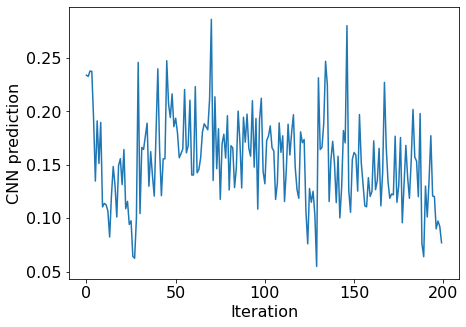

In [4]:
fig, ax = plt.subplots(1,1, figsize = [7,5])
p = ax.plot(1 - pred)
ax.set_xlabel('Iteration',fontsize = 16)
ax.set_ylabel('CNN prediction', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

In [5]:
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30", 
"C32.x", "C32.y", "C34.x", "C34.y"]

abr_lim = [2e-6, 2e-6, 2e-6, 3e-5, 3e-5, 3e-5, 3e-5, 4e-4, 3e-4, 3e-4, 3e-4, 3e-4]

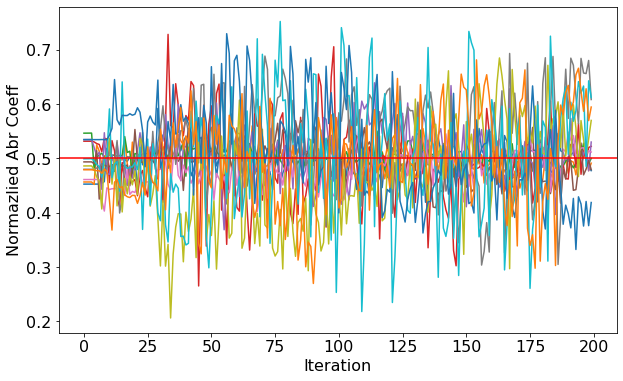

In [6]:
fig, ax = plt.subplots(1,1, figsize = [10,6])
for i in range(abr.shape[1]):
    p = ax.plot(abr[:,i])
ax.set_xlabel('Iteration',fontsize = 16)
ax.set_ylabel('Normazlied Abr Coeff', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.axhline(y=0.5, c='r')